In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style for thesis-ready plots
plt.style.use('seaborn-v0_8-paper')
sns.set_palette('colorblind')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 10

print("✓ Libraries imported")

✓ Libraries imported


## 1. Load Data and Define Predictions

### Evaluation Approach

**For SecurityEval Dataset:**
- **Prediction (TP)**: Tool detected the expected CWE in initial detection (`*_matches_expected = True`)
- **Ground Truth (GT)**: Expected CWE was found at ANY point in workflow (`gt_vulnerable = True`)
- **Metrics**: Precision, Recall, F1-Score based on expected CWE detection
- **Note**: Additional CWEs detected are tracked separately but NOT counted as false positives

This approach evaluates whether tools can detect the specific targeted vulnerability in each test case.

In [2]:
# Load labeled evaluation data
data_path = Path('data/evaluation_labeled.csv')

# Check if file exists
if not data_path.exists():
    print("❌ ERROR: evaluation_labeled.csv not found!")
    print("\nThis file should be created by running notebook 03_ground_truth_annotation.ipynb")
    print("Please complete ground truth annotation before running RQ2 analysis.")
    print("\nAlternatively, if you have the data with required columns, ensure it includes:")
    print("  - bandit_matches_expected (boolean: did Bandit detect expected CWE?)")
    print("  - semgrep_matches_expected (boolean: did Semgrep detect expected CWE?)")
    print("  - ast_matches_expected (boolean: did AST detect expected CWE?)")
    print("  - combined_matches_expected (boolean: did any tool detect expected CWE?)")
    print("  - gt_vulnerable (ground truth label: True if expected CWE found anywhere)")
    print("  - prompt_type (optional, for stratified analysis)")
    raise FileNotFoundError(f"Required file not found: {data_path}")

df = pd.read_csv(data_path)

print(f"✓ Loaded {len(df)} samples")
print(f"\nColumns: {list(df.columns)}")
print(f"\nGround truth distribution:")
print(df['gt_vulnerable'].value_counts())

✓ Loaded 84 samples

Columns: ['workflow_id', 'workflow', 'timestamp', 'file', 'source_file', 'prompt_type', 'prompt', 'llm_response', 'vulnerabilities_found', 'total_vulnerabilities_identified', 'total_vulnerabilities_fixed', 'total_vulnerabilities_remaining', 'initial_detection_bandit_count', 'initial_detection_bandit_cwes', 'initial_detection_semgrep_count', 'initial_detection_semgrep_cwes', 'initial_detection_ast_count', 'initial_detection_ast_cwes', 'iteration_detection_bandit_count', 'iteration_detection_bandit_cwes', 'iteration_detection_semgrep_count', 'iteration_detection_semgrep_cwes', 'iteration_detection_ast_count', 'iteration_detection_ast_cwes', 'iterations_count', 'fixed_cwes', 'remaining_cwes', 'fix_provider_llm', 'fix_provider_rule_based', 'fix_provider_unknown', 'fix_provider_llm_cwes', 'fix_provider_rule_cwes', 'fix_provider_unknown_cwes', 'unique_cwes_fixed', 'unique_cwes_remaining', 'unique_cwes_identified', 'gt_vulnerable', 'gt_cwes', 'gt_source', 'expected_cwe', 

In [3]:
# Define snippet-level predictions based on initial detection
# For SecurityEval: A snippet is predicted as vulnerable if the tool detected the expected CWE
# Using the *_matches_expected columns created in notebook 03

print("Using match columns from notebook 03...")
print("These indicate whether each tool detected the expected CWE in initial detection.\n")

# Convert boolean match columns to binary predictions (0/1)
df['bandit_pred'] = df['bandit_matches_expected'].astype(int)
df['semgrep_pred'] = df['semgrep_matches_expected'].astype(int)
df['ast_pred'] = df['ast_matches_expected'].astype(int)
df['combined_pred'] = df['combined_matches_expected'].astype(int)

# Ground truth: gt_vulnerable is True only if expected CWE was found anywhere in workflow
df['gt'] = df['gt_vulnerable'].astype(int)

print("Prediction summary (initial detection of expected CWE):")
print(f"Bandit detected expected CWE: {df['bandit_pred'].sum()}/{len(df)} ({df['bandit_pred'].mean()*100:.1f}%)")
print(f"Semgrep detected expected CWE: {df['semgrep_pred'].sum()}/{len(df)} ({df['semgrep_pred'].mean()*100:.1f}%)")
print(f"AST detected expected CWE: {df['ast_pred'].sum()}/{len(df)} ({df['ast_pred'].mean()*100:.1f}%)")
print(f"Combined detected expected CWE: {df['combined_pred'].sum()}/{len(df)} ({df['combined_pred'].mean()*100:.1f}%)")
print(f"\nGround truth positives (expected CWE found anywhere): {df['gt'].sum()}/{len(df)} ({df['gt'].mean()*100:.1f}%)")

Using match columns from notebook 03...
These indicate whether each tool detected the expected CWE in initial detection.

Prediction summary (initial detection of expected CWE):
Bandit detected expected CWE: 3/84 (3.6%)
Semgrep detected expected CWE: 3/84 (3.6%)
AST detected expected CWE: 3/84 (3.6%)
Combined detected expected CWE: 7/84 (8.3%)

Ground truth positives (expected CWE found anywhere): 29/84 (34.5%)


## 2. Confusion Matrix Computation

In [4]:
def compute_confusion(y_true, y_pred):
    """
    Compute confusion matrix components.
    
    Parameters:
    -----------
    y_true : array-like
        Ground truth binary labels (0 or 1)
    y_pred : array-like
        Predicted binary labels (0 or 1)
    
    Returns:
    --------
    dict with keys: TP, FP, FN, TN
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    
    return {
        'TP': int(TP),
        'FP': int(FP),
        'FN': int(FN),
        'TN': int(TN)
    }

print("✓ Confusion matrix function defined")

✓ Confusion matrix function defined


In [5]:
# Compute confusion matrices for all tools
tools = ['bandit', 'semgrep', 'ast', 'combined']
confusion_results = {}

for tool in tools:
    pred_col = f'{tool}_pred'
    confusion_results[tool] = compute_confusion(df['gt'], df[pred_col])

# Create DataFrame
confusion_df = pd.DataFrame(confusion_results).T
confusion_df.index.name = 'Tool'
confusion_df = confusion_df[['TP', 'FP', 'FN', 'TN']]  # Order columns

print("\n" + "="*60)
print("CONFUSION MATRIX RESULTS")
print("="*60)
print(confusion_df)
print("="*60)


CONFUSION MATRIX RESULTS
          TP  FP  FN  TN
Tool                    
bandit     3   0  26  55
semgrep    3   0  26  55
ast        3   0  26  55
combined   7   0  22  55


## 3. Compute Detection Metrics

In [6]:
def compute_metrics(confusion_dict):
    """
    Compute Precision, Recall, F1-score, and Accuracy from confusion matrix.
    Handles divide-by-zero safely.
    
    Parameters:
    -----------
    confusion_dict : dict
        Dictionary with keys TP, FP, FN, TN
    
    Returns:
    --------
    dict with metrics
    """
    TP = confusion_dict['TP']
    FP = confusion_dict['FP']
    FN = confusion_dict['FN']
    TN = confusion_dict['TN']
    
    # Precision: TP / (TP + FP)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    
    # Recall: TP / (TP + FN)
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    
    # F1-score: 2 * (Precision * Recall) / (Precision + Recall)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    # Accuracy: (TP + TN) / (TP + FP + FN + TN)
    total = TP + FP + FN + TN
    accuracy = (TP + TN) / total if total > 0 else 0.0
    
    return {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Accuracy': accuracy
    }

print("✓ Metrics computation function defined")

✓ Metrics computation function defined


In [ ]:
# Compute metrics for all tools
metrics_results = {}

for tool in tools:
    metrics_results[tool] = compute_metrics(confusion_results[tool])

# Create metrics DataFrame
metrics_df = pd.DataFrame(metrics_results).T
metrics_df.index.name = 'Tool'

# Round for display
metrics_display = metrics_df.round(4)

print("\n" + "="*70)
print("DETECTION METRICS")
print("="*70)
print(metrics_display)
print("="*70)


DeVAIC-STYLE DETECTION METRICS
          Precision  Recall  F1-Score  Accuracy
Tool                                           
bandit          1.0  0.1034    0.1875    0.6905
semgrep         1.0  0.1034    0.1875    0.6905
ast             1.0  0.1034    0.1875    0.6905
combined        1.0  0.2414    0.3889    0.7381


In [8]:
# Combine confusion matrix and metrics into one table
full_metrics_df = pd.concat([confusion_df, metrics_df], axis=1)

# Export to CSV
output_path = Path('data/rq2_metrics_table.csv')
full_metrics_df.to_csv(output_path)
print(f"\n✓ Metrics table exported to: {output_path}")

# Display full table
print("\nFull Metrics Table:")
display(full_metrics_df.round(4))


✓ Metrics table exported to: data\rq2_metrics_table.csv

Full Metrics Table:


,TP,FP,FN,TN,Precision,Recall,F1-Score,Accuracy
Tool,,,,,,,,
bandit,3,0,26,55,1.0,0.1034,0.1875,0.6905
semgrep,3,0,26,55,1.0,0.1034,0.1875,0.6905
ast,3,0,26,55,1.0,0.1034,0.1875,0.6905
combined,7,0,22,55,1.0,0.2414,0.3889,0.7381


## 4. Thesis-Ready Visualizations

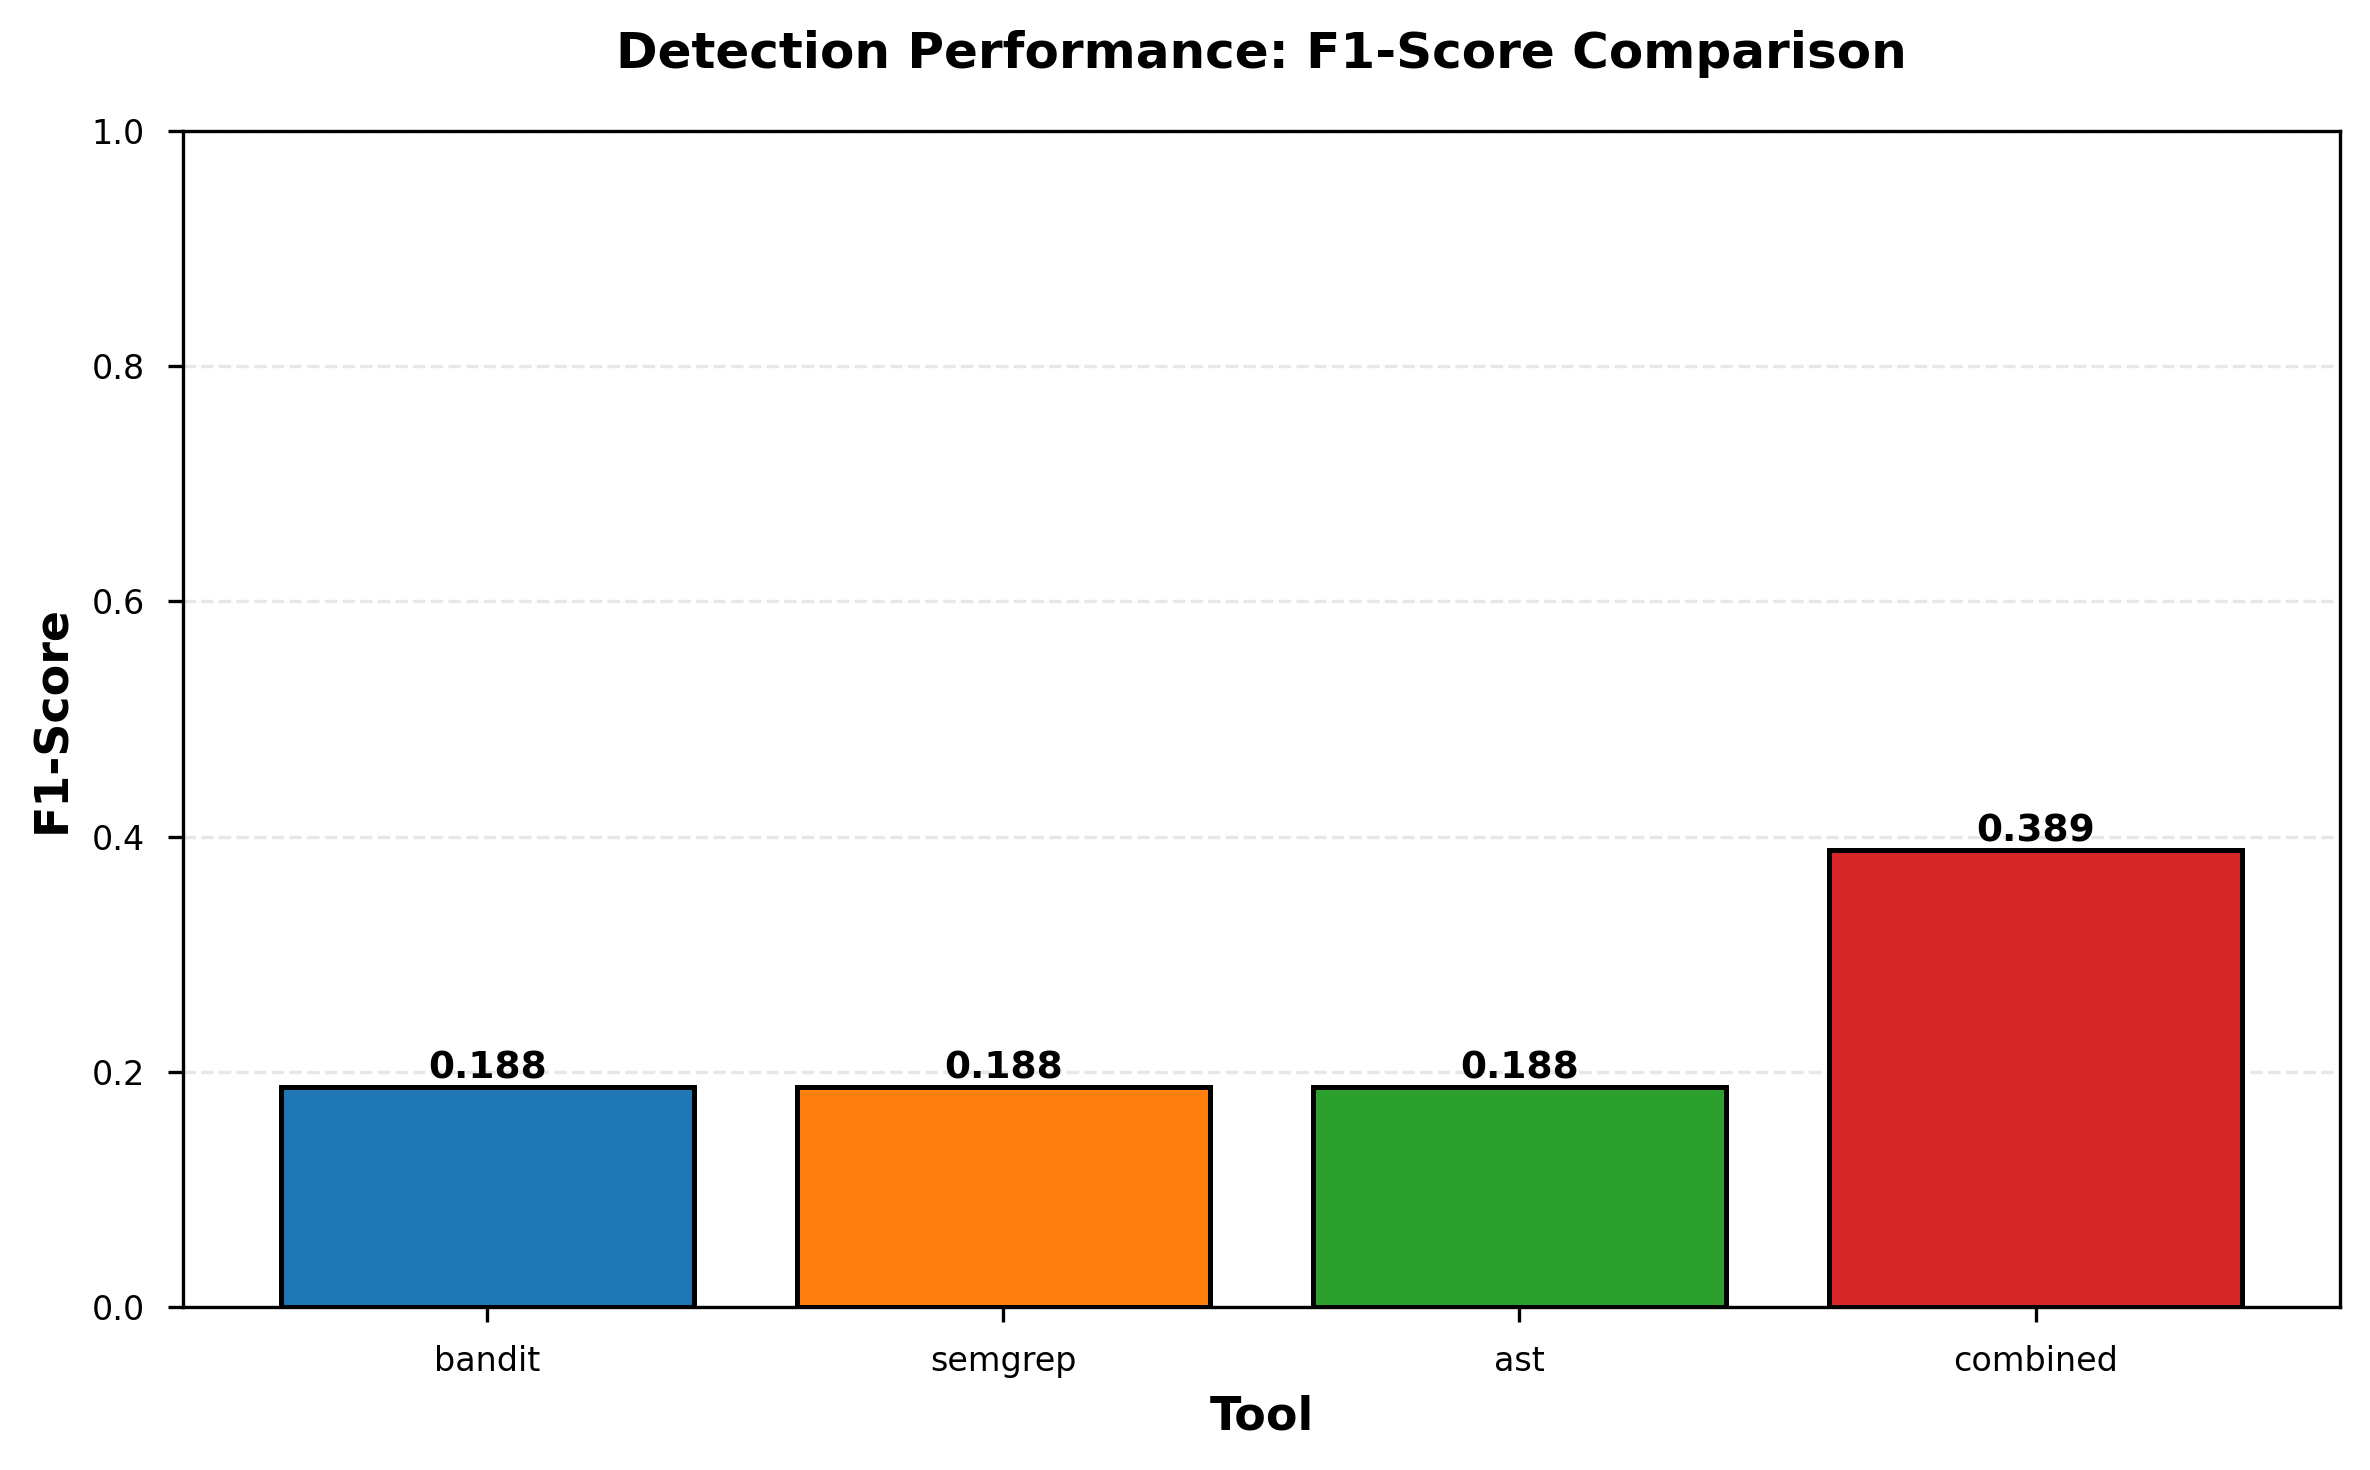

✓ F1-score comparison plot saved


In [9]:
# Plot 1: F1-Score Comparison
fig, ax = plt.subplots(figsize=(8, 5))

f1_scores = metrics_df['F1-Score']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

bars = ax.bar(f1_scores.index, f1_scores.values, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Tool', fontsize=11, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
ax.set_title('Detection Performance: F1-Score Comparison', fontsize=12, fontweight='bold', pad=15)
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('data/rq2_f1_comparison.png', bbox_inches='tight')
plt.show()

print("✓ F1-score comparison plot saved")

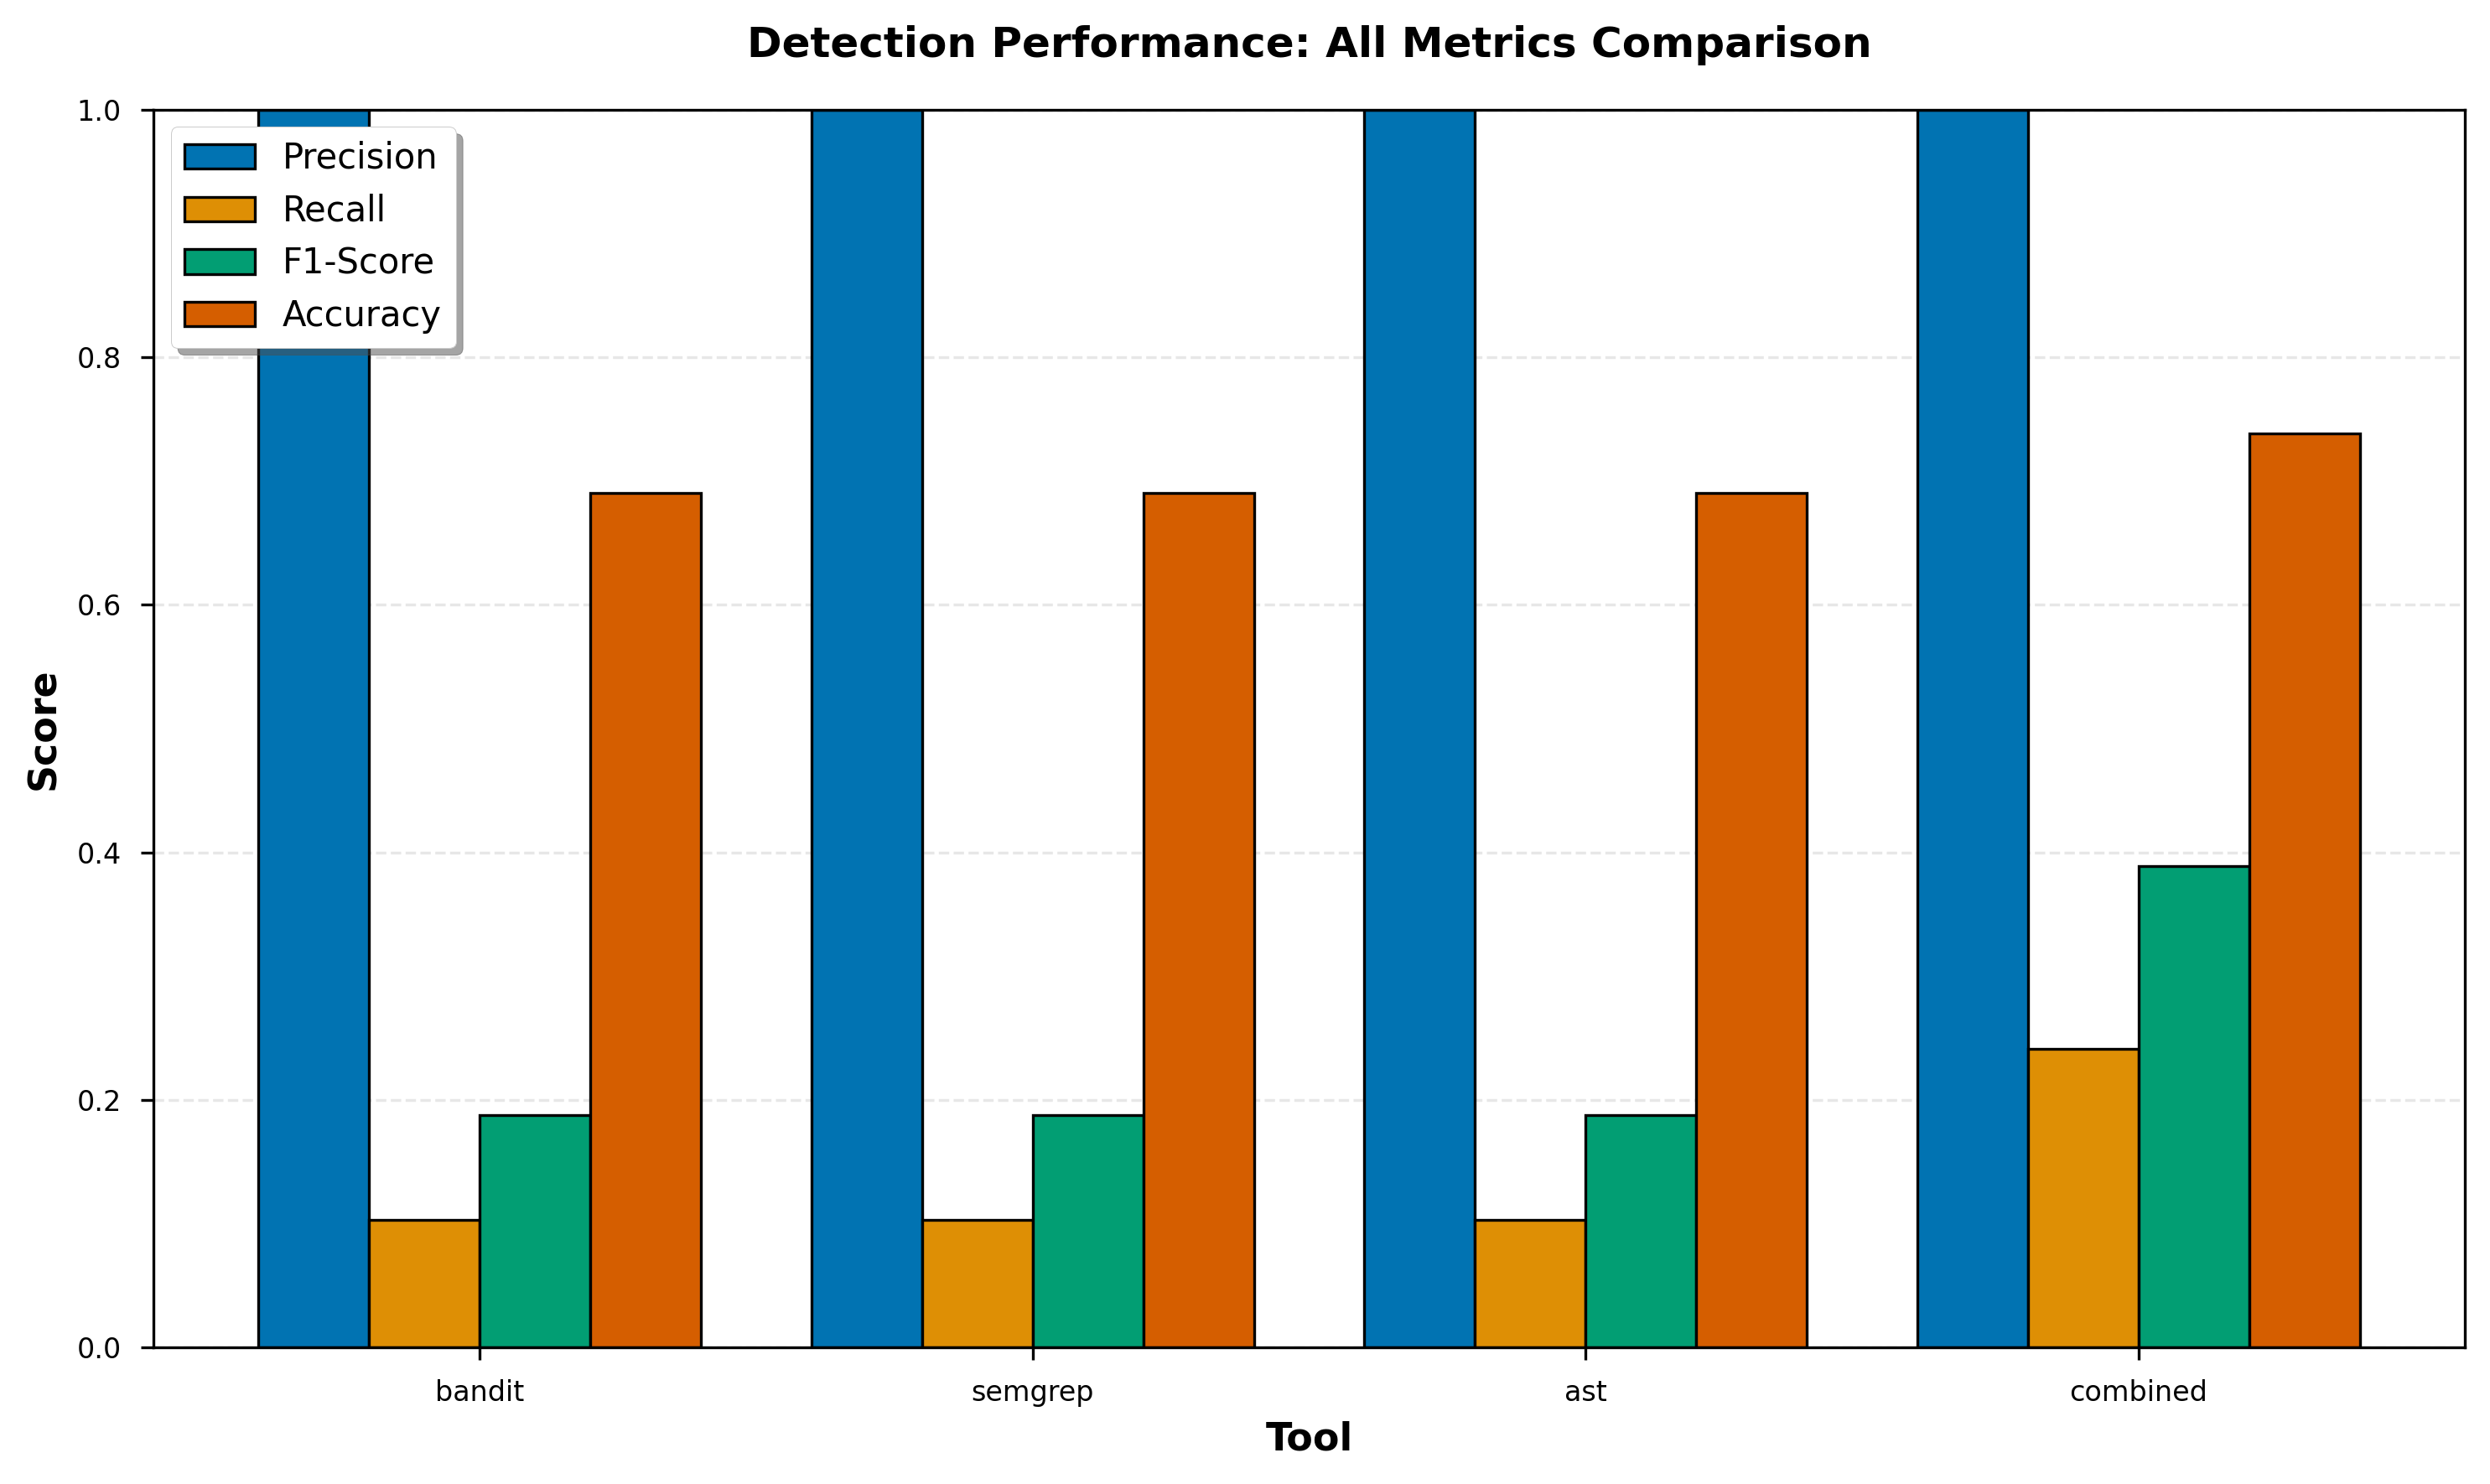

✓ All metrics comparison plot saved


In [10]:
# Plot 2: Grouped Bar Chart for All Metrics
fig, ax = plt.subplots(figsize=(10, 6))

metrics_to_plot = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
x = np.arange(len(tools))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    offset = width * (i - 1.5)
    values = [metrics_df.loc[tool, metric] for tool in tools]
    ax.bar(x + offset, values, width, label=metric, edgecolor='black', linewidth=0.8)

ax.set_xlabel('Tool', fontsize=11, fontweight='bold')
ax.set_ylabel('Score', fontsize=11, fontweight='bold')
ax.set_title('Detection Performance: All Metrics Comparison', fontsize=12, fontweight='bold', pad=15)
ax.set_xticks(x)
ax.set_xticklabels(tools)
ax.set_ylim([0, 1.0])
ax.legend(loc='upper left', frameon=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('data/rq2_all_metrics_comparison.png', bbox_inches='tight')
plt.show()

print("✓ All metrics comparison plot saved")

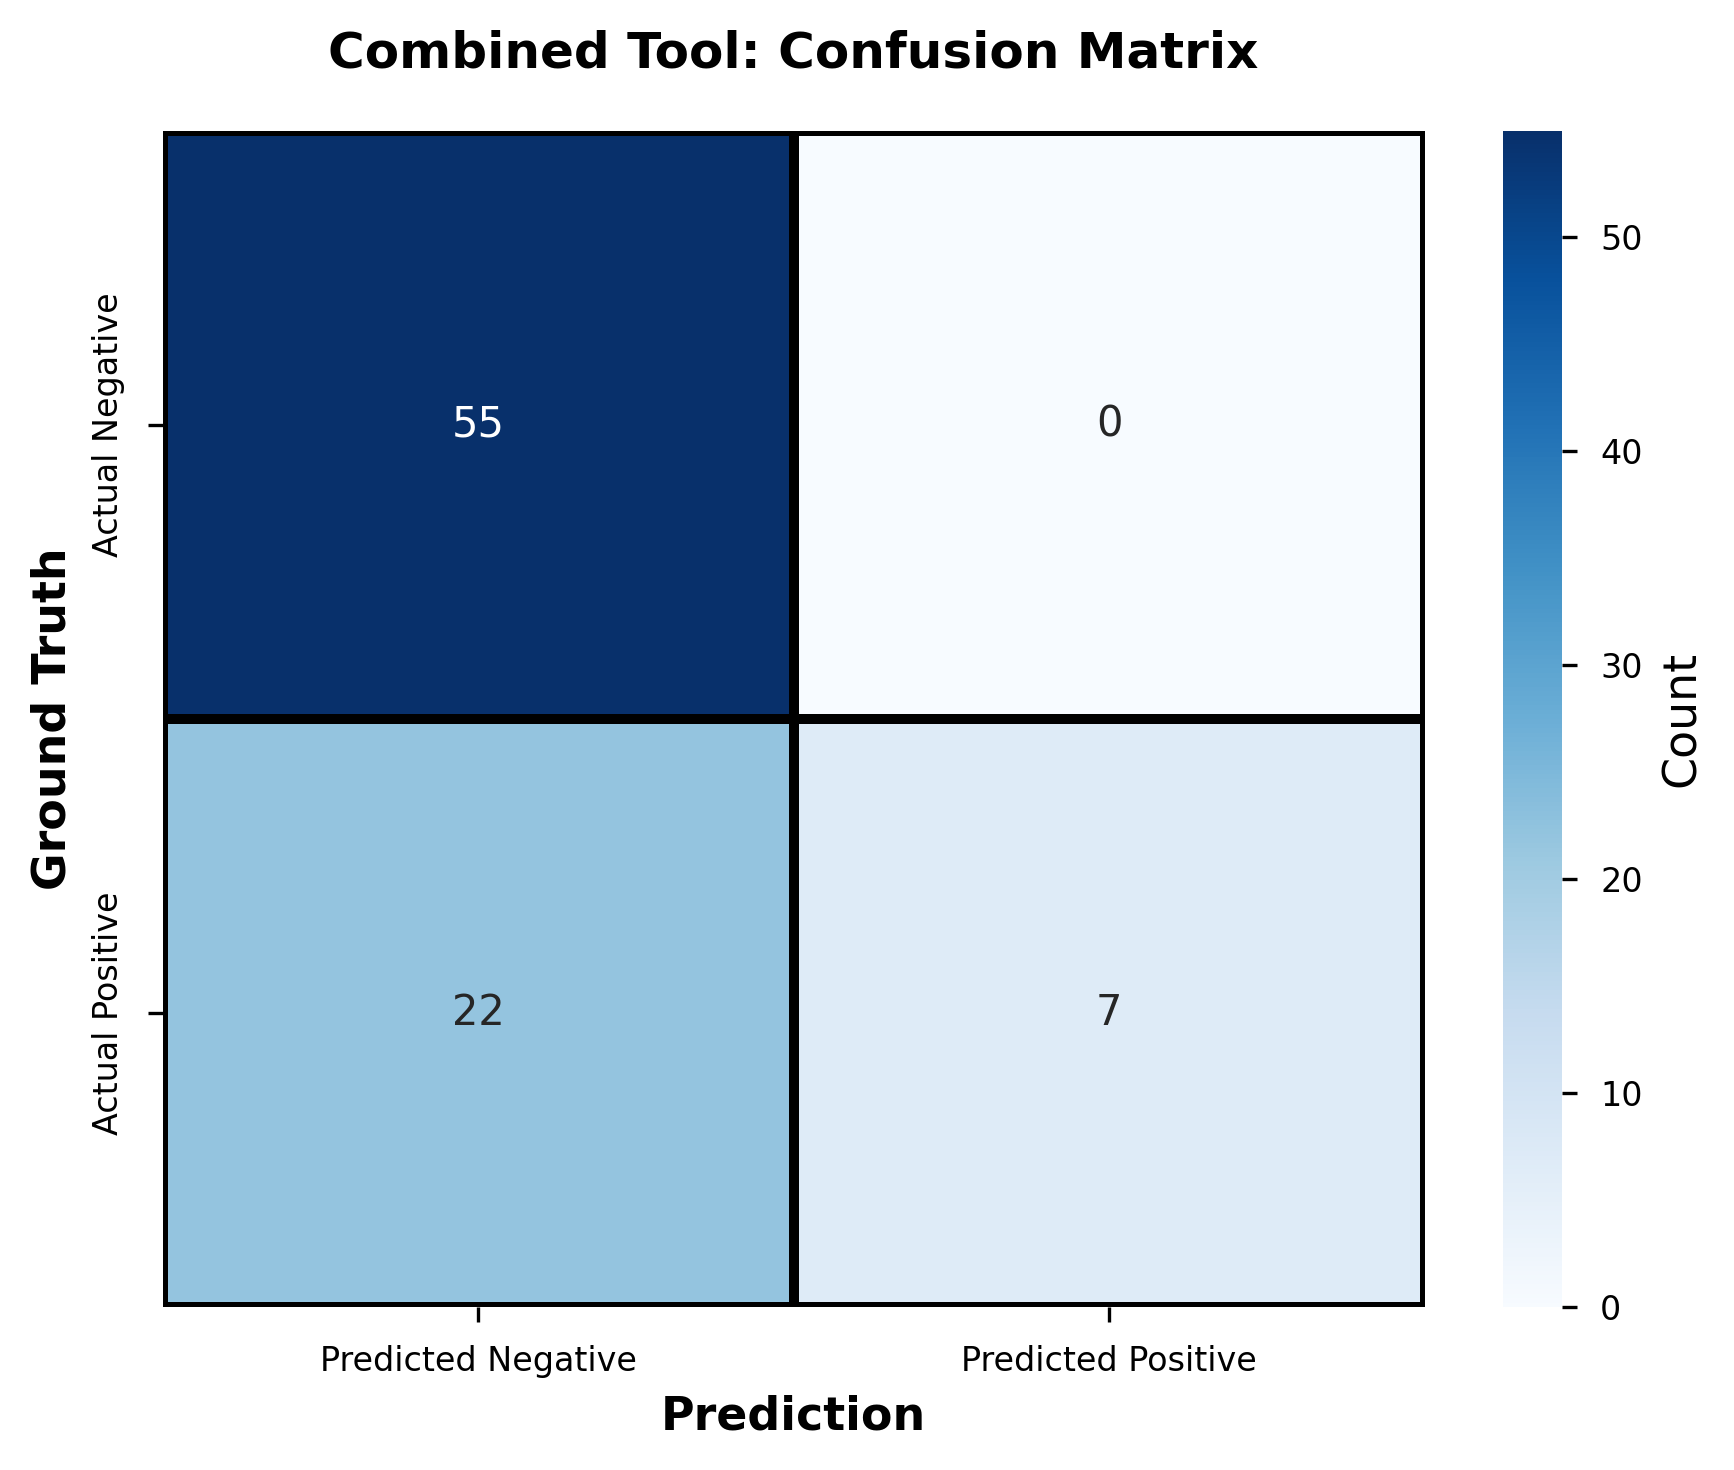

✓ Confusion matrix heatmap saved


In [11]:
# Plot 3: Confusion Matrix Heatmap for Combined Tool
fig, ax = plt.subplots(figsize=(6, 5))

# Create confusion matrix in standard format
conf_matrix = np.array([
    [confusion_results['combined']['TN'], confusion_results['combined']['FP']],
    [confusion_results['combined']['FN'], confusion_results['combined']['TP']]
])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'],
            cbar_kws={'label': 'Count'},
            linewidths=2, linecolor='black',
            ax=ax)

ax.set_title('Combined Tool: Confusion Matrix', fontsize=12, fontweight='bold', pad=15)
ax.set_xlabel('Prediction', fontsize=11, fontweight='bold')
ax.set_ylabel('Ground Truth', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('data/rq2_confusion_matrix_combined.png', bbox_inches='tight')
plt.show()

print("✓ Confusion matrix heatmap saved")

## 5. Stratified Metrics by Prompt Type

In [12]:
# Check if prompt_type column exists
if 'prompt_type' not in df.columns:
    print("WARNING: 'prompt_type' column not found in data.")
    print("Available columns:", list(df.columns))
    print("\nAttempting to infer prompt_type from snippet_id...")
    
    # Try to infer from snippet_id or file paths
    if 'snippet_id' in df.columns:
        df['prompt_type'] = df['snippet_id'].apply(
            lambda x: 'SecurityEval' if 'SecurityEval' in str(x) else 'Manual'
        )
    else:
        print("Cannot infer prompt_type. Creating dummy column for demonstration.")
        df['prompt_type'] = 'Unknown'

print("\nPrompt type distribution:")
print(df['prompt_type'].value_counts())


Prompt type distribution:
prompt_type
SecurityEval    42
Manual          42
Name: count, dtype: int64


In [13]:
# Compute stratified metrics
prompt_types = df['prompt_type'].unique()
stratified_results = []

for prompt_type in prompt_types:
    subset = df[df['prompt_type'] == prompt_type]
    
    if len(subset) == 0:
        continue
    
    for tool in tools:
        pred_col = f'{tool}_pred'
        
        # Compute confusion matrix for this subset
        conf = compute_confusion(subset['gt'], subset[pred_col])
        
        # Compute metrics
        metrics = compute_metrics(conf)
        
        # Combine results
        result = {
            'Prompt_Type': prompt_type,
            'Tool': tool,
            'Sample_Count': len(subset),
            **conf,
            **metrics
        }
        
        stratified_results.append(result)

# Create DataFrame
stratified_df = pd.DataFrame(stratified_results)

# Reorder columns
column_order = ['Prompt_Type', 'Tool', 'Sample_Count', 'TP', 'FP', 'FN', 'TN', 
                'Precision', 'Recall', 'F1-Score', 'Accuracy']
stratified_df = stratified_df[column_order]

print("\n" + "="*90)
print("STRATIFIED METRICS BY PROMPT TYPE")
print("="*90)
display(stratified_df.round(4))
print("="*90)


STRATIFIED METRICS BY PROMPT TYPE


,Prompt_Type,Tool,Sample_Count,TP,FP,FN,TN,Precision,Recall,F1-Score,Accuracy
0,SecurityEval,bandit,42,3,0,5,34,1.0,0.375,0.5455,0.8810
1,SecurityEval,semgrep,42,3,0,5,34,1.0,0.375,0.5455,0.8810
2,SecurityEval,ast,42,3,0,5,34,1.0,0.375,0.5455,0.8810
3,SecurityEval,combined,42,7,0,1,34,1.0,0.875,0.9333,0.9762
4,Manual,bandit,42,0,0,21,21,0.0,0.000,0.0000,0.5000
5,Manual,semgrep,42,0,0,21,21,0.0,0.000,0.0000,0.5000
6,Manual,ast,42,0,0,21,21,0.0,0.000,0.0000,0.5000
7,Manual,combined,42,0,0,21,21,0.0,0.000,0.0000,0.5000


In [14]:
# Export stratified metrics
stratified_output_path = Path('data/rq2_metrics_by_prompt_type.csv')
stratified_df.to_csv(stratified_output_path, index=False)
print(f"✓ Stratified metrics exported to: {stratified_output_path}")

✓ Stratified metrics exported to: data\rq2_metrics_by_prompt_type.csv


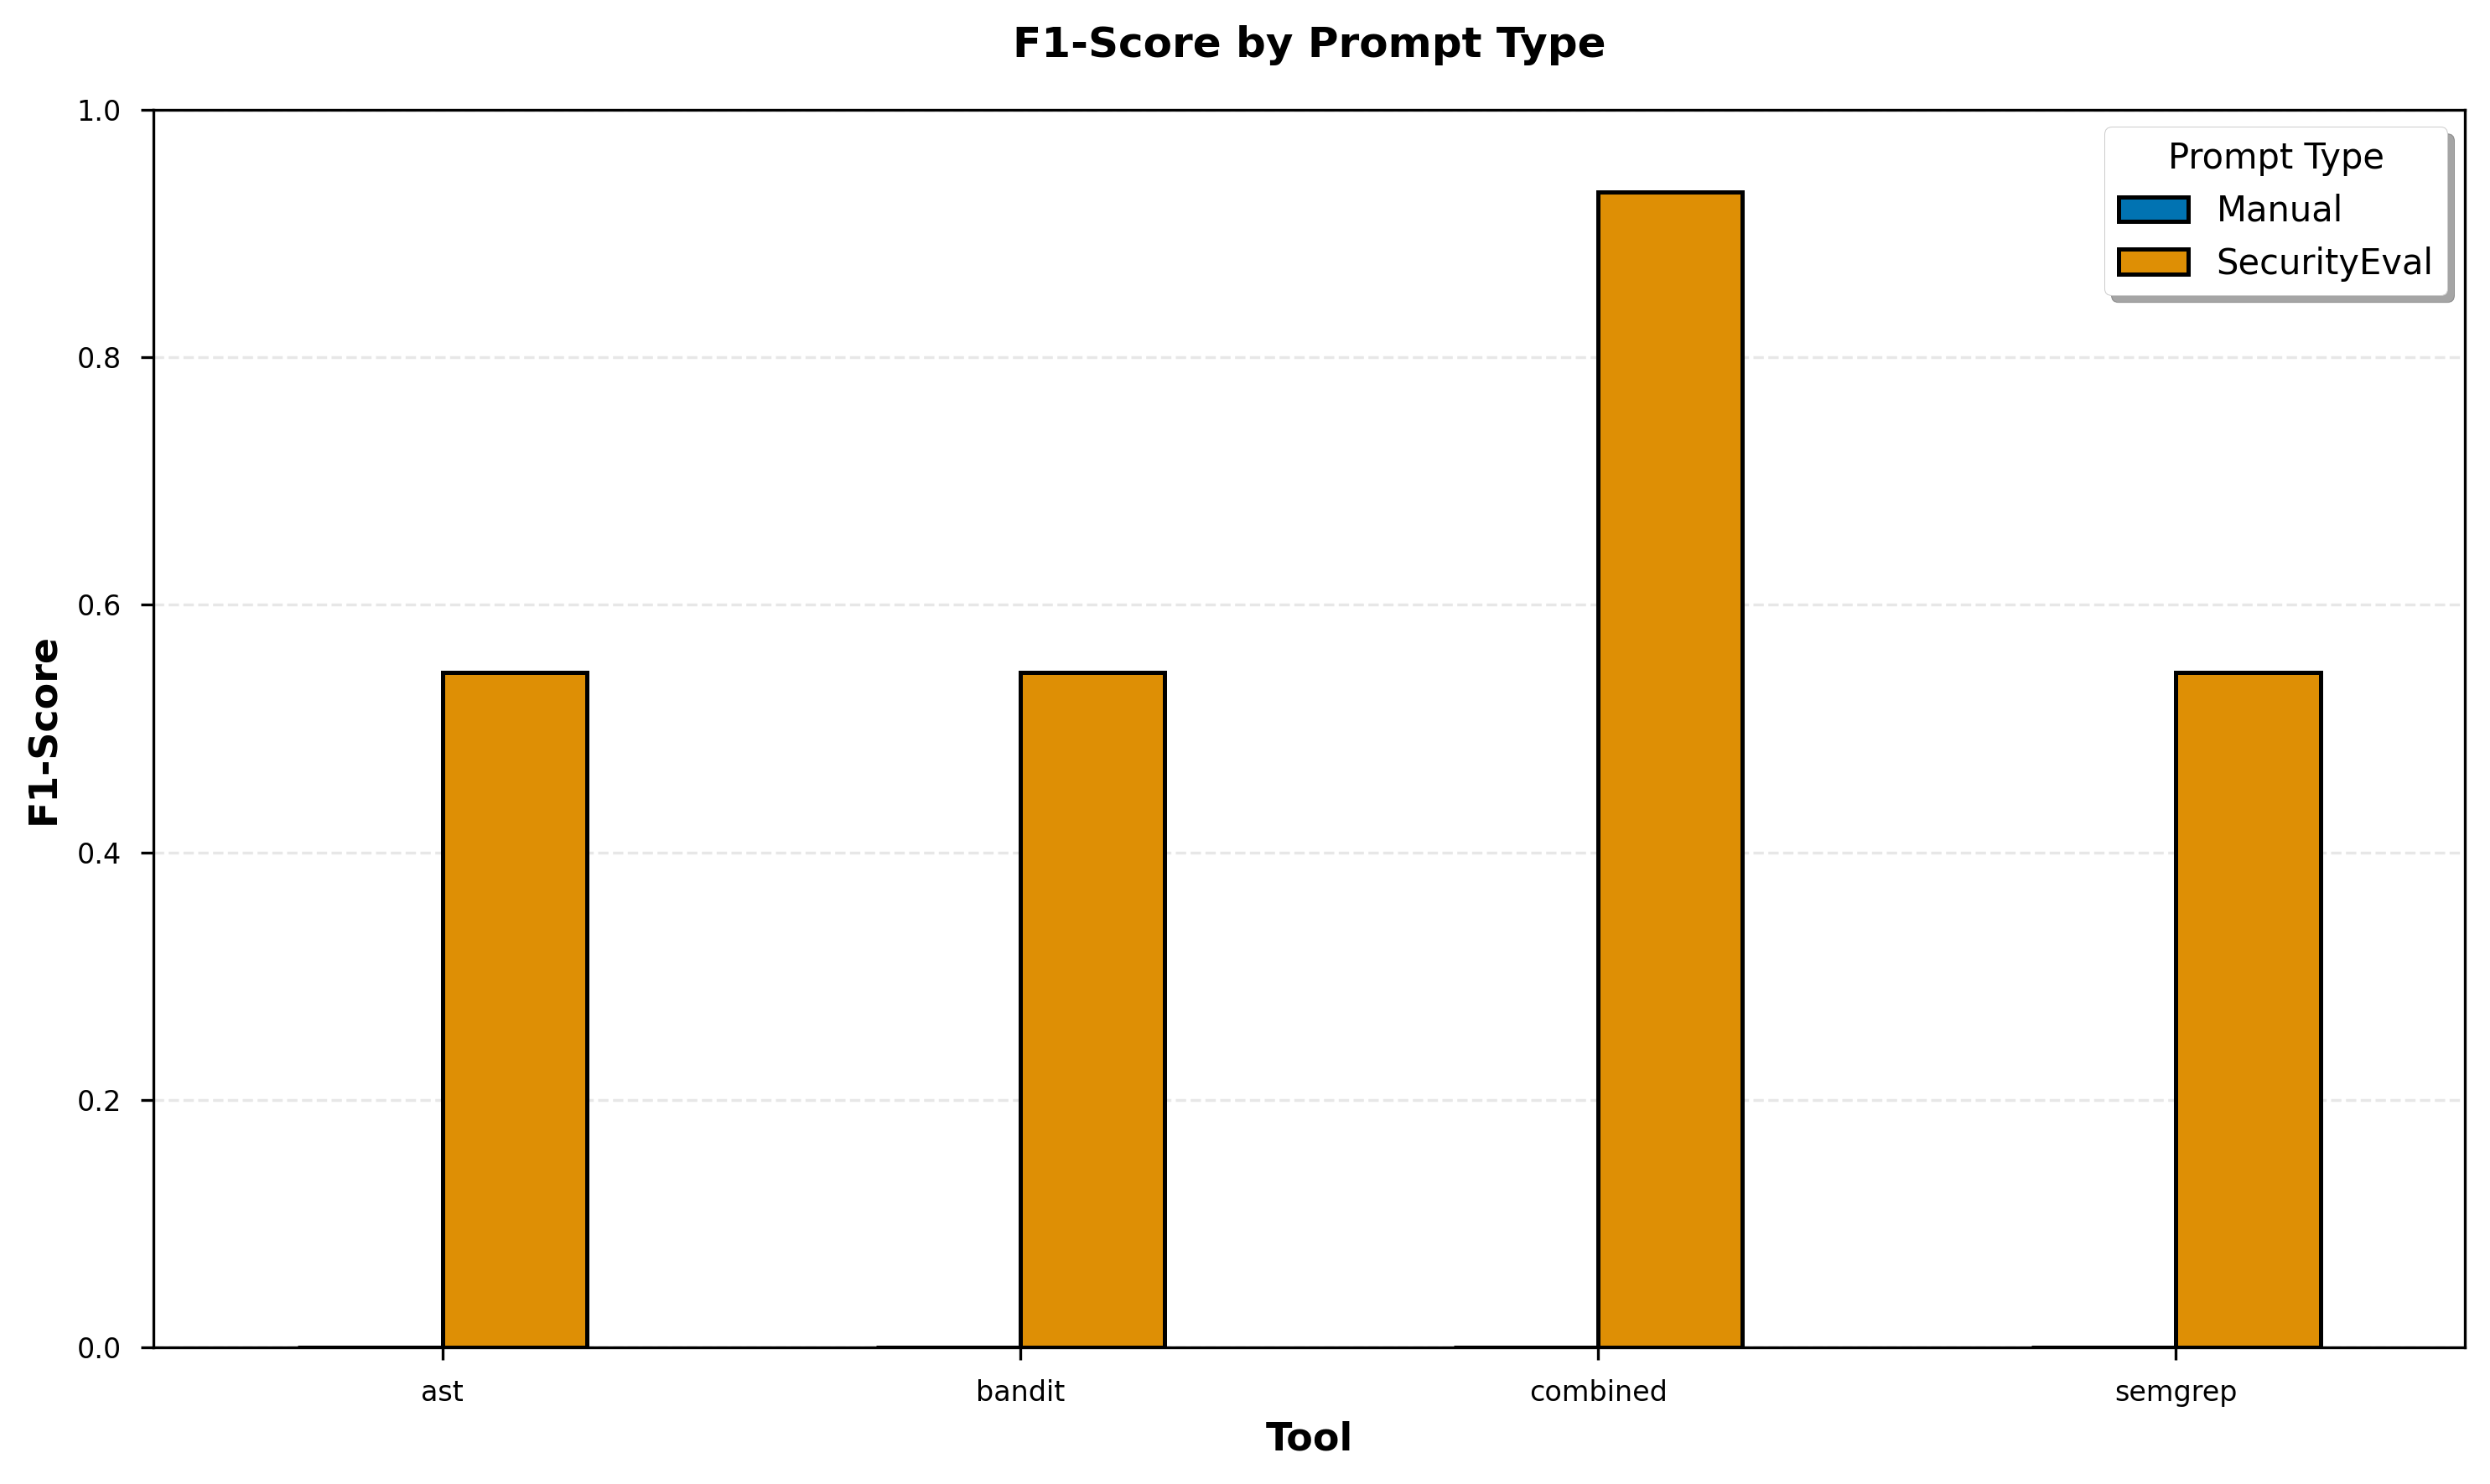

✓ Stratified F1-score plot saved


In [15]:
# Plot stratified F1-scores
if len(prompt_types) > 1:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Pivot data for grouped bar chart
    pivot_data = stratified_df.pivot(index='Tool', columns='Prompt_Type', values='F1-Score')
    
    pivot_data.plot(kind='bar', ax=ax, edgecolor='black', linewidth=1.2)
    
    ax.set_xlabel('Tool', fontsize=11, fontweight='bold')
    ax.set_ylabel('F1-Score', fontsize=11, fontweight='bold')
    ax.set_title('F1-Score by Prompt Type', fontsize=12, fontweight='bold', pad=15)
    ax.set_ylim([0, 1.0])
    ax.legend(title='Prompt Type', frameon=True, shadow=True)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig('data/rq2_f1_by_prompt_type.png', bbox_inches='tight')
    plt.show()
    
    print("✓ Stratified F1-score plot saved")
else:
    print("Only one prompt type found - skipping stratified plot")

## Summary

In [16]:
print("\n" + "="*70)
print("RQ2 DETECTION METRICS ANALYSIS - COMPLETE")
print("="*70)
print("\nKey Findings:")
print(f"  • Best F1-Score: {metrics_df['F1-Score'].idxmax()} ({metrics_df['F1-Score'].max():.3f})")
print(f"  • Best Precision: {metrics_df['Precision'].idxmax()} ({metrics_df['Precision'].max():.3f})")
print(f"  • Best Recall: {metrics_df['Recall'].idxmax()} ({metrics_df['Recall'].max():.3f})")
print(f"  • Best Accuracy: {metrics_df['Accuracy'].idxmax()} ({metrics_df['Accuracy'].max():.3f})")

print("\nOutputs Generated:")
print("  • rq2_metrics_table.csv")
print("  • rq2_metrics_by_prompt_type.csv")
print("  • rq2_f1_comparison.png")
print("  • rq2_all_metrics_comparison.png")
print("  • rq2_confusion_matrix_combined.png")
if len(prompt_types) > 1:
    print("  • rq2_f1_by_prompt_type.png")
print("="*70)


RQ2 DETECTION METRICS ANALYSIS - COMPLETE

Key Findings:
  • Best F1-Score: combined (0.389)
  • Best Precision: bandit (1.000)
  • Best Recall: combined (0.241)
  • Best Accuracy: combined (0.738)

Outputs Generated:
  • rq2_metrics_table.csv
  • rq2_metrics_by_prompt_type.csv
  • rq2_f1_comparison.png
  • rq2_all_metrics_comparison.png
  • rq2_confusion_matrix_combined.png
  • rq2_f1_by_prompt_type.png
